## Modeling Soybean yield using tabular and raster data

In [ ]:
### Libraries

In [2]:
location = 'dataset/'

from IPython.core.display import display, HTML
from IPython.display import display_html
display(  HTML( '<style>.container { width:60% !important; }</style>' )  )

import os, random, time, datetime
import pandas as pd, re
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, scipy
from sklearn import *
import missingno as msno
import xgboost as xgb

from glob import glob
from scipy.io import loadmat

import scipy.stats as stats, random, math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.colors import ListedColormap

plt.style.use('classic')

# import remote sensing libraries
import geopandas as pdd
import rasterio as rio, shapely
import earthpy.plot as ep
from osgeo import gdal


# ml ai lib 
import tensorflow as tf, imageio, PIL
from tensorflow import *
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

## Set Jupyter notebook display options for pandas
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 6

C:\Users\madhur\AppData\Local\Temp\ipykernel_23504\4184719459.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<br> 

### A. ML model to predict Soybean yield using Tabular data

The fields in the data are as follow:

    Variety: Variety of the Soybean crop
    S1, S2, S3, S4 : Soil components
    M1, M2, M3: Crop management parameters
    W1, W2, W3, W4: Weather components
    Yield: Crop yield value

<br>

In [3]:
soyb_df = pd.read_csv( location + 'soybean_data.csv'  )
soyb_df


,Variety,S_1,S_2,S_3,S_4,M_1,M_2,M_3,W_1,W_2,W_3,W_4,Yield
0,1,4.0900,15.3,396.90,4.98,0.00632,18.0,6.575,2.381979,0.475522,65.2,296.350195,24.0
1,2,4.9671,17.8,396.90,9.14,0.02731,0.0,6.421,7.071148,0.509165,78.9,241.620198,21.6
2,2,4.9671,17.8,392.83,4.03,0.02729,0.0,7.185,6.896941,0.580673,61.1,241.551476,34.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,2.1675,21.0,396.90,5.64,0.06076,0.0,6.976,11.854205,0.777569,91.0,273.421726,23.9
504,1,2.3889,21.0,393.45,6.48,0.10959,0.0,6.794,11.765196,0.679057,89.3,273.913622,22.0
505,1,2.5050,21.0,396.90,7.88,0.04741,0.0,6.030,12.007563,0.615699,80.8,273.623418,11.9


False

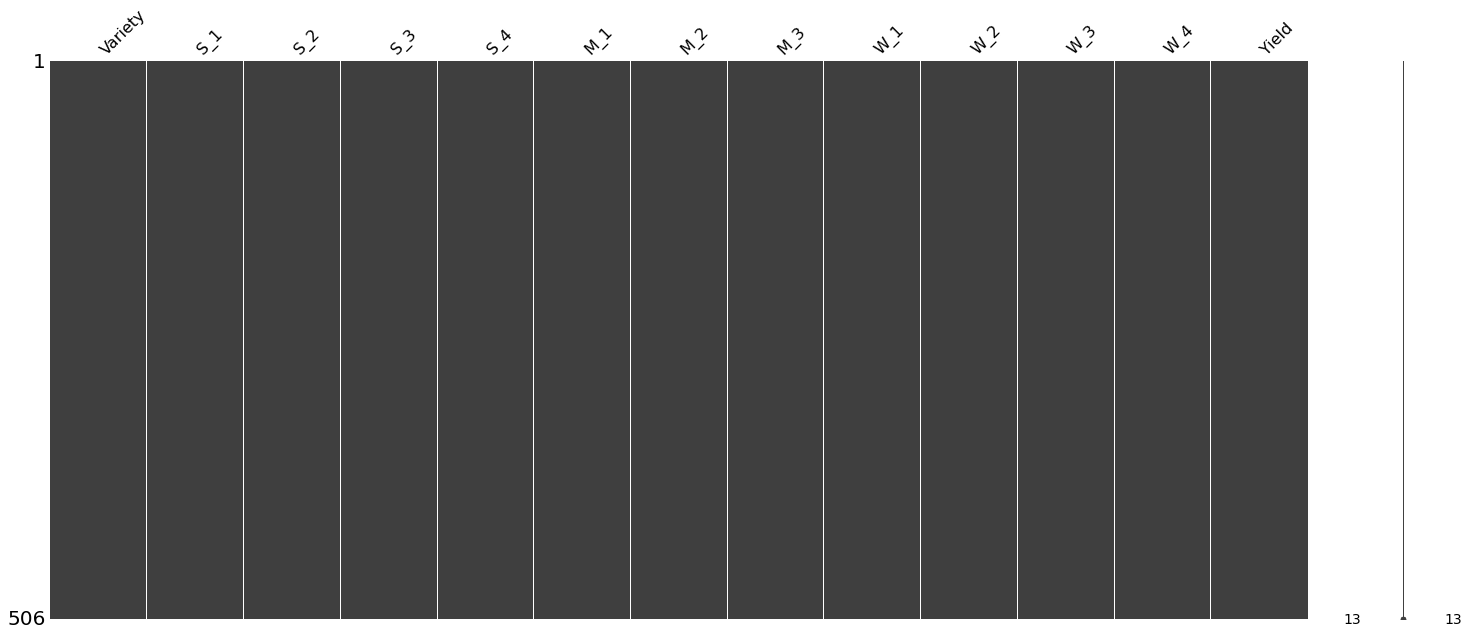

In [4]:
# checking for missing values

msno.matrix( soyb_df )
soyb_df.isnull().values.any()

<br>

#### Data preprocessing
<br>

In [5]:
from statsmodels.graphics.gofplots import qqplot

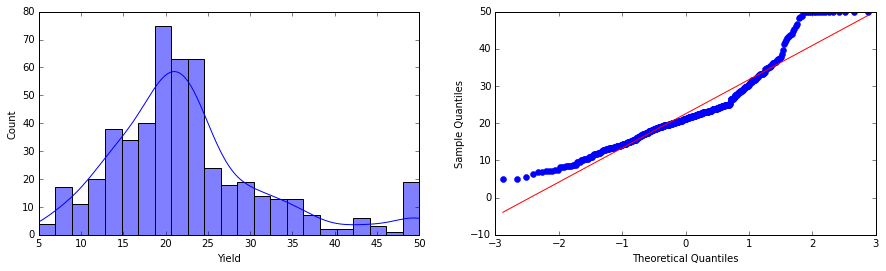

In [6]:
fg, ax = plt.subplots(  1,2, figsize= (15,4)  )

sns.histplot(  data= soyb_df, x= 'Yield', kde= True, ax= ax[0]  )
qqplot(  data= soyb_df.Yield, line= 's', ax= ax[1]  )

plt.show()

#### `Normalization` (Min-Max Scalar)

In this approach, the data is scaled to a fixed range — usually 0 to 1.
In contrast to standardization, the cost of having this bounded range is that we will end up with smaller standard deviations, which can <u>suppress the effect of outliers</u>. Thus <u>MinMax Scalar is sensitive to outliers</u>.

A Min-Max scaling is typically done via the following equation:<br><br>
$X_{n o r m}=\frac{X-X_{\min }}{X_{\max }-X_{\min }}$

In [7]:
minMaxScaler_Obj = sklearn.preprocessing.MinMaxScaler()

normalized_data_np = minMaxScaler_Obj.fit_transform( soyb_df )

normalized_df = pd.DataFrame(  normalized_data_np, columns= soyb_df.columns )

normalized_df

,Variety,S_1,S_2,S_3,S_4,M_1,M_2,M_3,W_1,W_2,W_3,W_4,Yield
0,0.000000,0.269203,0.287234,1.000000,0.089680,0.000000,0.18,0.577505,0.069166,0.352517,0.641607,0.208954,0.422222
1,0.043478,0.348962,0.553191,1.000000,0.204470,0.000236,0.00,0.547998,0.239056,0.384409,0.782698,0.104596,0.368889
2,0.043478,0.348962,0.553191,0.989737,0.063466,0.000236,0.00,0.694386,0.232744,0.452197,0.599382,0.104465,0.660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0.000000,0.094381,0.893617,1.000000,0.107892,0.000612,0.00,0.654340,0.412347,0.638850,0.907312,0.165235,0.420000
504,0.000000,0.114514,0.893617,0.991301,0.131071,0.001161,0.00,0.619467,0.409122,0.545463,0.889804,0.166173,0.377778
505,0.000000,0.125072,0.893617,1.000000,0.169702,0.000462,0.00,0.473079,0.417903,0.485402,0.802266,0.165619,0.153333


In [8]:
# train test split

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                            normalized_df.drop( columns= 'Yield' ), soyb_df['Yield'],
                            test_size= 20./100, random_state= 10 )

xtrn, xval, ytrn, yval = sklearn.model_selection.train_test_split(  xtrn, ytrn,
                                                                    test_size= 25./100, random_state= 10 )

print(  xtrn.shape, xval.shape, xtst.shape, ytrn.shape, yval.shape, ytst.shape  )

(303, 12) (101, 12) (102, 12) (303,) (101,) (102,)


### Ridge Regression

In [10]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = sklearn.linear_model.Ridge()
parameters = { 'alpha': alphas }
ridge_regressor = sklearn.model_selection.GridSearchCV( estimator= ridge, param_grid= parameters,
                                                        scoring='neg_mean_squared_error', cv= 5 )
ridge_regressor.fit( xtrn, ytrn )

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2....
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03])},
             scoring='neg_mean_squared_error')

In [11]:
print( ridge_regressor.best_params_, ridge_regressor.best_score_ )

{'alpha': 0.3289666123287841} -23.656438267385404


### Lasso Regression

In [12]:
lasso = sklearn.linear_model.Lasso()
parameters = { 'alpha': alphas }
lasso_regressor = sklearn.model_selection.GridSearchCV( estimator= lasso, param_grid= parameters,
                                                        scoring='neg_mean_squared_error', cv= 5 )

lasso_regressor.fit(  xtrn, ytrn )

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2....
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03])},
             scoring='neg_mean_squared_error')

In [13]:
print( lasso_regressor.best_params_, lasso_regressor.best_score_ )

{'alpha': 0.005} -23.93269312795432


In [14]:
yhat_lasso_val = lasso_regressor.predict( xval )
yhat_ridge_val = ridge_regressor.predict( xval )

print( f'Ridge - r2 - val : { sklearn.metrics.r2_score(yval, yhat_lasso_val) }' )
print( f'Lesso r2 - val): {  sklearn.metrics.r2_score(yval, yhat_ridge_val) } ')

Ridge - r2 - val : 0.6535462316097709
Lesso r2 - val): 0.6598340609175892 


In [15]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [16]:
yhat_lasso_tst = lasso_regressor.predict( xtst )
yhat_ridge_tst = ridge_regressor.predict( xtst )

metrics_tst_ls = {
    'RMSE': [ np.sqrt(mse(ytst,yhat_ridge_tst)), np.sqrt(mse(ytst,yhat_lasso_tst)) ], 
    'MSE':  [ mse(ytst,yhat_ridge_tst), mse(ytst,yhat_lasso_tst) ],
    'MAE':  [ mae(ytst,yhat_ridge_tst), mae(ytst,yhat_lasso_tst) ], 
    'R2':   [ r2_score(ytst, yhat_ridge_tst), r2_score(ytst, yhat_lasso_tst) ]
                 }  
metrics_tst_df = pd.DataFrame( metrics_tst_ls, index = ['Ridge', 'Lasso'] )

print(metrics_tst_df)

           RMSE        MSE       MAE        R2
Ridge  6.085387  37.031938  4.234358  0.645901
Lasso  6.087148  37.053371  4.238309  0.645696


### XGBOOST model

In [27]:
# dMatrix

xytrn_DMtrx = xgb.DMatrix(  data= xtrn, label= ytrn )
xytst_DMtrx = xgb.DMatrix(  data= xtst, label= ytst )

# initial hyper param dictn
pDictn = {  'objective': 'reg:squarederror', 'max_depth': 10   }
lambda_ls =  np.logspace(-6,0,50)
rmse_ls = []

# iter over lambda

for e_lambda in lambda_ls:
    
    pDictn['lambda'] = e_lambda
    
    # pass param with nascent k-v into cv
    xgb_CV  = xgb.cv(  params= pDictn, dtrain= xytrn_DMtrx,  num_boost_round= 3, nfold= 6, metrics= 'rmse',
                       as_pandas= True, seed= 10  )
    
    rmse_ls.append( xgb_CV['test-rmse-mean'].min() )
    
# convert lists to df

rmse_df = pd.DataFrame(  data= zip(lambda_ls,rmse_ls), columns= ['lambda_l2','rmse'] )
print( rmse_df.head() )

C:\Users\madhur\.conda\envs\mlai\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   lambda_l2      rmse
0   0.000001  8.497120
1   0.000001  8.496620
2   0.000002  8.513429
3   0.000002  8.505439
4   0.000003  8.502555


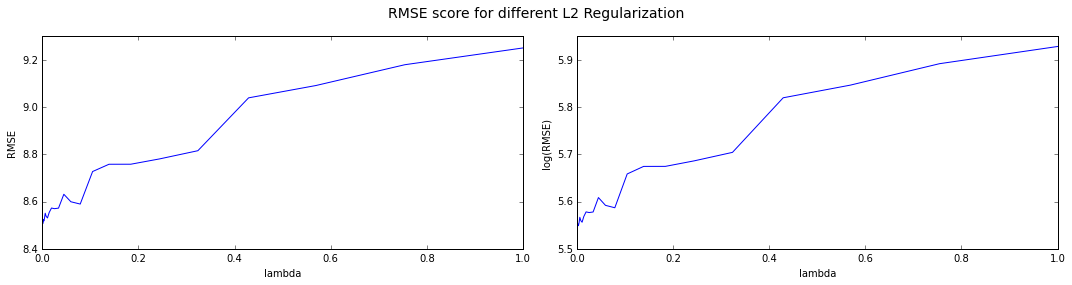

In [28]:
fg, ax = plt.subplots( 1,2, figsize= (15,4) )

ax[0].plot( rmse_df.lambda_l2, rmse_df.rmse );       ax[1].plot( rmse_df.lambda_l2, (rmse_df.rmse)**.8 )

ax[0].set( xlabel= 'lambda', ylabel= 'RMSE' );       ax[1].set( xlabel= 'lambda', ylabel= 'log(RMSE)'  )
fg.suptitle( 'RMSE score for different L2 Regularization', size= 14  )

# ax[1].set_yscale('log', base= 10)

plt.tight_layout(); plt.show()

#### Visualizing individual XGBoost trees

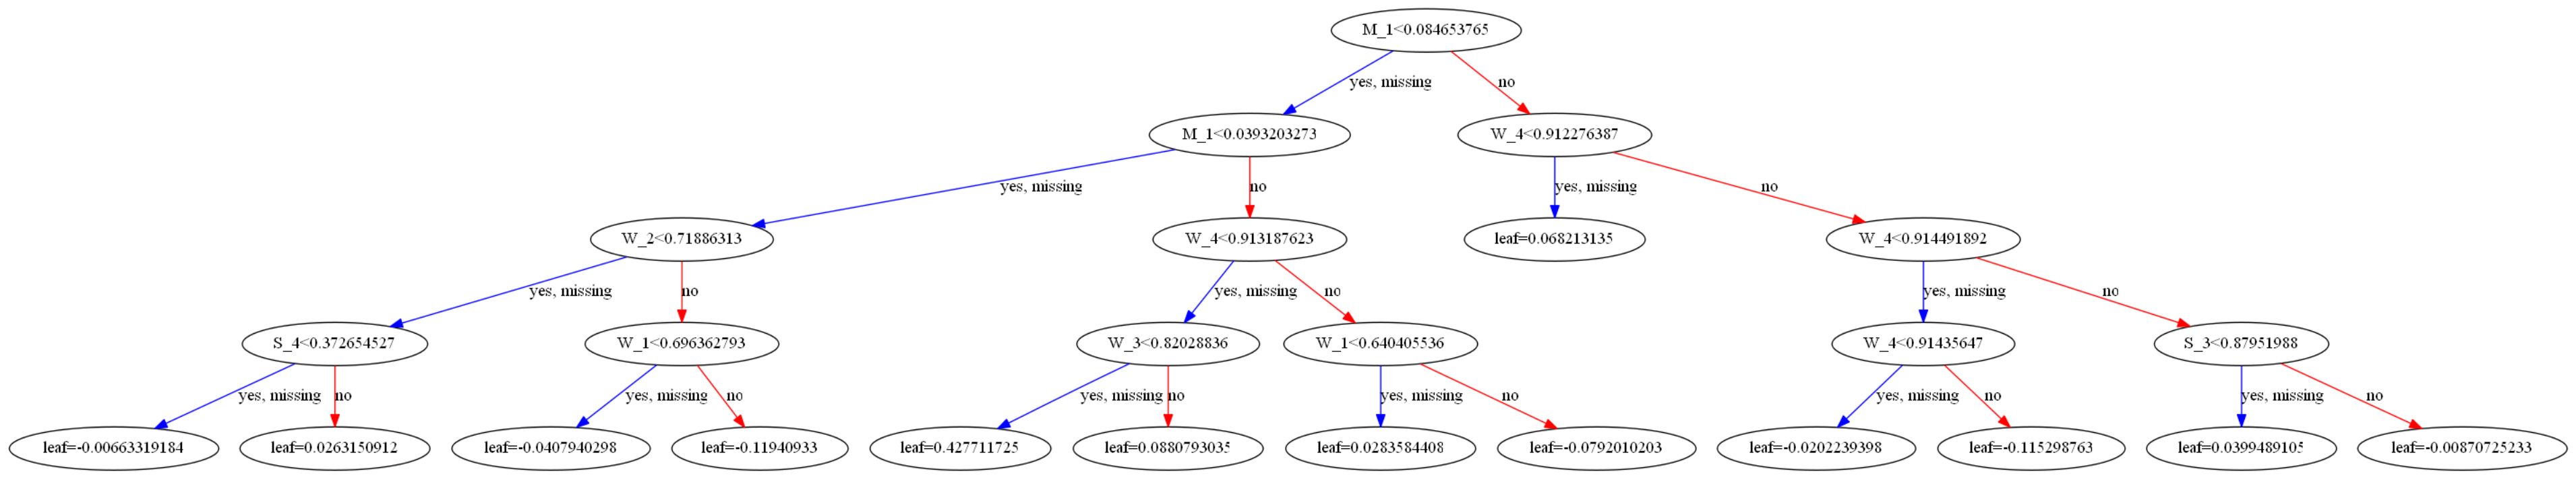

In [30]:
# model train/fit

total_trees = 50

pDictn = {  'objective':'reg:squarederror', 'max_depth':4, 'lambda':0.02  }

xgb_Reg_est = xgb.train(  params= pDictn, dtrain= xytrn_DMtrx, num_boost_round= total_trees  )

fg,ax = plt.subplots( figsize= (80,10) )

xgb.plot_tree( booster= xgb_Reg_est, ax= ax,
               num_trees= total_trees - 1  # <- last tree              
             )
plt.tight_layout()

#### Visualizing feature importances

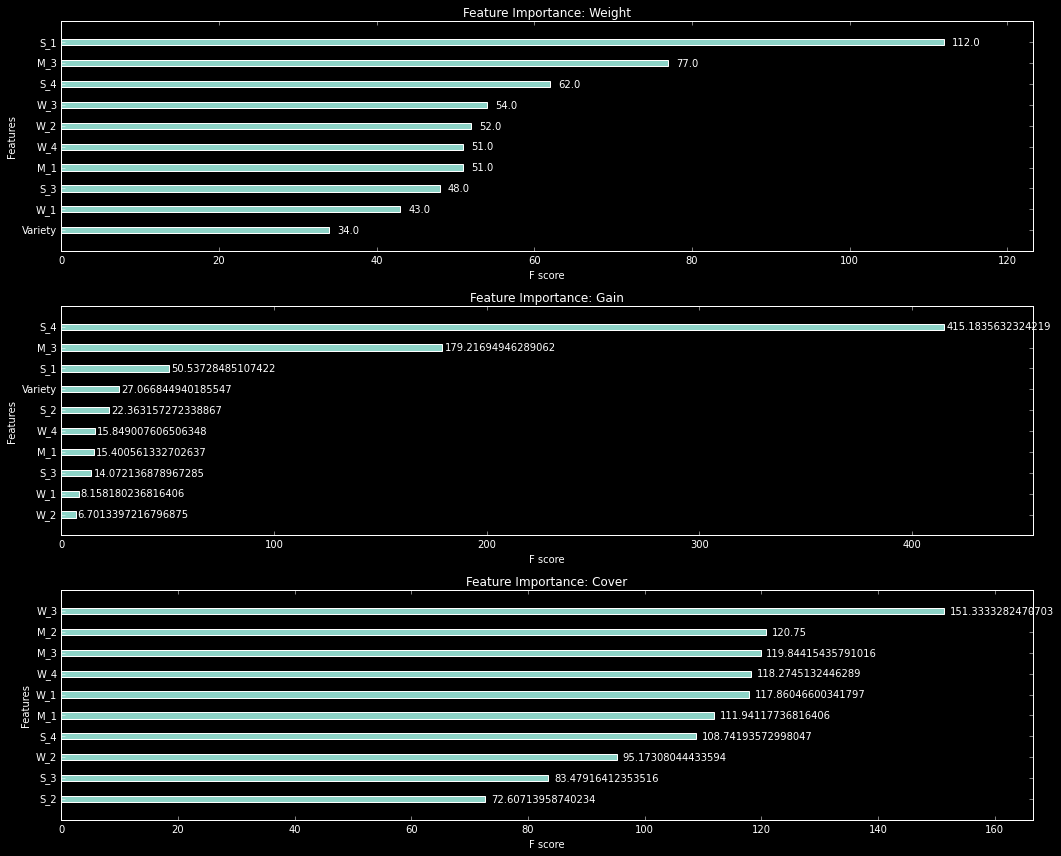

In [31]:
plt.style.use('dark_background')

fg,ax = plt.subplots( 3,1, figsize= (15,4*3) )

xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'weight', ax= ax[0], title= 'Feature Importance: Weight'  )
xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'gain',   ax= ax[1], title= 'Feature Importance: Gain'  )
xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'cover',  ax= ax[2], title= 'Feature Importance: Cover'  )

plt.tight_layout();  plt.show()